# Neural CDE

This example trains a [Neural CDE](https://arxiv.org/abs/1810.01367) (a "continuous time RNN") to distinguish clockwise from counter-clockwise spirals.

A neural CDE looks like

$y(t) = y(0) + \int_0^t f_\theta(y(s)) \mathrm{d}x(s)$

Where $f_\theta$ is a neural network, and $x$ is your data. The right hand side is a matrix-vector product between them. The integral is a Riemann--Stieltjes integral.

!!! info

    Provided the path $x$ is differentiable then the Riemann--Stieltjes integral can be converted into a normal integral:
    
    $y(t) = y(0) + \int_0^t f_\theta(y(s)) \frac{\mathrm{d}x}{\mathrm{d}s}(s) \mathrm{d}s$
    
    and in this case you can actually solve the CDE as an ODE. Indeed this is what we do below.
    
    Typically the path $x$ is constructed as a continuous interpolation of your input data. This is an approach that often makes a lot of sense when dealing with irregular data, densely sampled data etc. (i.e. the things that an RNN or Transformer might not work so well on.)

**Reference:**

```bibtex
@incollection{kidger2020neuralcde,
    title={Neural Controlled Differential Equations for Irregular Time Series},
    author={Kidger, Patrick and Morrill, James and Foster, James and Lyons, Terry},
    booktitle={Advances in Neural Information Processing Systems},
    publisher={Curran Associates, Inc.},
    year={2020},
}
```

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/neural_cde.ipynb).

In [1]:
import math
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import matplotlib
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax


matplotlib.rcParams.update({"font.size": 30})

First let's define the vector field for the CDE.

In [2]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP
    data_size: int
    hidden_size: int

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.data_size = data_size
        self.hidden_size = hidden_size
        self.mlp = eqx.nn.MLP(
            in_size=hidden_size,
            out_size=hidden_size * data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.softplus,
            # Note the use of a tanh final activation function. This is important to
            # stop the model blowing up. (Just like how GRUs and LSTMs constrain the
            # rate of change of their hidden states.)
            final_activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, y, args):
        return self.mlp(y).reshape(self.hidden_size, self.data_size)

Now wrap up the whole CDE solve into a model.

In this case we cap the neural CDE with a linear layer and sigmoid, to perform binary classification.

In [3]:
class NeuralCDE(eqx.Module):
    initial: eqx.nn.MLP
    func: Func
    linear: eqx.nn.Linear

    def __init__(self, data_size, hidden_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        ikey, fkey, lkey = jr.split(key, 3)
        self.initial = eqx.nn.MLP(data_size, hidden_size, width_size, depth, key=ikey)
        self.func = Func(data_size, hidden_size, width_size, depth, key=fkey)
        self.linear = eqx.nn.Linear(hidden_size, 1, key=lkey)

    def __call__(self, ts, coeffs, evolving_out=False):
        # Each sample of data consists of some timestamps `ts`, and some `coeffs`
        # parameterising a control path. These are used to produce a continuous-time
        # input path `control`.
        control = diffrax.CubicInterpolation(ts, coeffs)
        term = diffrax.ControlTerm(self.func, control).to_ode()
        solver = diffrax.Tsit5()
        dt0 = None
        y0 = self.initial(control.evaluate(ts[0]))
        if evolving_out:
            saveat = diffrax.SaveAt(ts=ts)
        else:
            saveat = diffrax.SaveAt(t1=True)
        solution = diffrax.diffeqsolve(
            term,
            solver,
            ts[0],
            ts[-1],
            dt0,
            y0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=saveat,
        )
        if evolving_out:
            prediction = jax.vmap(lambda y: jnn.sigmoid(self.linear(y))[0])(solution.ys)
        else:
            (prediction,) = jnn.sigmoid(self.linear(solution.ys[-1]))
        return prediction

Toy dataset of spirals.

We interpolate the samples with Hermite cubic splines with backward differences, which were introduced in [https://arxiv.org/abs/2106.11028](https://arxiv.org/abs/2106.11028). (And produces better results than the natural cubic splines used in the original neural CDE paper.)

!!! danger "Time is a channel"

    Note the inclusion of time as a channel of the data! This is a subtle point that is often accidentally missed. If you include it then the model has enough information so that in theory it's actually a universal approximator. If you forget it then the model probably won't work very well...
    
    If a CDE ever isn't training very well, make sure to ask yourself "did I include time as a channel?"

In [4]:
def get_data(dataset_size, add_noise, *, key):
    theta_key, noise_key = jr.split(key, 2)
    length = 100
    theta = jr.uniform(theta_key, (dataset_size,), minval=0, maxval=2 * math.pi)
    y0 = jnp.stack([jnp.cos(theta), jnp.sin(theta)], axis=-1)
    ts = jnp.broadcast_to(jnp.linspace(0, 4 * math.pi, length), (dataset_size, length))
    matrix = jnp.array([[-0.3, 2], [-2, -0.3]])
    ys = jax.vmap(
        lambda y0i, ti: jax.vmap(lambda tij: jsp.linalg.expm(tij * matrix) @ y0i)(ti)
    )(y0, ts)
    ys = jnp.concatenate([ts[:, :, None], ys], axis=-1)  # time is a channel
    ys = ys.at[: dataset_size // 2, :, 1].multiply(-1)
    if add_noise:
        ys = ys + jr.normal(noise_key, ys.shape) * 0.1
    coeffs = jax.vmap(diffrax.backward_hermite_coefficients)(ts, ys)
    labels = jnp.zeros((dataset_size,))
    labels = labels.at[: dataset_size // 2].set(1.0)
    _, _, data_size = ys.shape
    return ts, coeffs, labels, data_size

In [5]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

The main entry point. Try running `main()` to train the neural CDE.

In [6]:
def main(
    dataset_size=256,
    add_noise=False,
    batch_size=32,
    lr=1e-2,
    steps=20,
    hidden_size=8,
    width_size=128,
    depth=1,
    seed=5678,
):
    key = jr.PRNGKey(seed)
    train_data_key, test_data_key, model_key, loader_key = jr.split(key, 4)

    ts, coeffs, labels, data_size = get_data(
        dataset_size, add_noise, key=train_data_key
    )

    model = NeuralCDE(data_size, hidden_size, width_size, depth, key=model_key)

    # Training loop like normal.

    @eqx.filter_jit
    def loss(model, ti, label_i, coeff_i):
        pred = jax.vmap(model)(ti, coeff_i)
        # Binary cross-entropy
        bxe = label_i * jnp.log(pred) + (1 - label_i) * jnp.log(1 - pred)
        bxe = -jnp.mean(bxe)
        acc = jnp.mean((pred > 0.5) == (label_i == 1))
        return bxe, acc

    grad_loss = eqx.filter_value_and_grad(loss, has_aux=True)

    @eqx.filter_jit
    def make_step(model, data_i, opt_state):
        ti, label_i, *coeff_i = data_i
        (bxe, acc), grads = grad_loss(model, ti, label_i, coeff_i)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return bxe, acc, model, opt_state

    optim = optax.adam(lr)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    for step, data_i in zip(
        range(steps), dataloader((ts, labels) + coeffs, batch_size, key=loader_key)
    ):
        start = time.time()
        bxe, acc, model, opt_state = make_step(model, data_i, opt_state)
        end = time.time()
        print(
            f"Step: {step}, Loss: {bxe}, Accuracy: {acc}, Computation time: "
            f"{end - start}"
        )

    ts, coeffs, labels, _ = get_data(dataset_size, add_noise, key=test_data_key)
    bxe, acc = loss(model, ts, labels, coeffs)
    print(f"Test loss: {bxe}, Test Accuracy: {acc}")

    # Plot results
    sample_ts = ts[-1]
    sample_coeffs = tuple(c[-1] for c in coeffs)
    pred = model(sample_ts, sample_coeffs, evolving_out=True)
    interp = diffrax.CubicInterpolation(sample_ts, sample_coeffs)
    values = jax.vmap(interp.evaluate)(sample_ts)
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection="3d")
    ax1.plot(sample_ts, values[:, 1], c="dodgerblue")
    ax1.plot(sample_ts, values[:, 2], c="dodgerblue", label="Data")
    ax1.plot(sample_ts, pred, c="crimson", label="Classification")
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_xlabel("t")
    ax1.legend()
    ax2.plot(values[:, 1], values[:, 2], c="dodgerblue", label="Data")
    ax2.plot(values[:, 1], values[:, 2], pred, c="crimson", label="Classification")
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("Classification")
    plt.tight_layout()
    plt.savefig("neural_cde.png")
    plt.show()

Step: 0, Loss: 2.5234897136688232, Accuracy: 0.5, Computation time: 27.177752256393433
Step: 1, Loss: 4.682699203491211, Accuracy: 0.5, Computation time: 0.5112535953521729
Step: 2, Loss: 1.9817578792572021, Accuracy: 0.46875, Computation time: 0.4303276538848877
Step: 3, Loss: 0.909335732460022, Accuracy: 0.375, Computation time: 0.42275118827819824
Step: 4, Loss: 0.5238552093505859, Accuracy: 0.96875, Computation time: 0.3412055969238281
Step: 5, Loss: 0.5987676382064819, Accuracy: 0.5625, Computation time: 0.4041574001312256
Step: 6, Loss: 0.5615957975387573, Accuracy: 0.5625, Computation time: 0.3387322425842285
Step: 7, Loss: 0.5031553506851196, Accuracy: 0.625, Computation time: 0.4076976776123047
Step: 8, Loss: 0.3657313883304596, Accuracy: 0.84375, Computation time: 0.35105156898498535
Step: 9, Loss: 0.34929466247558594, Accuracy: 0.9375, Computation time: 0.42032384872436523
Step: 10, Loss: 0.2539682686328888, Accuracy: 1.0, Computation time: 0.3486146926879883
Step: 11, Loss:

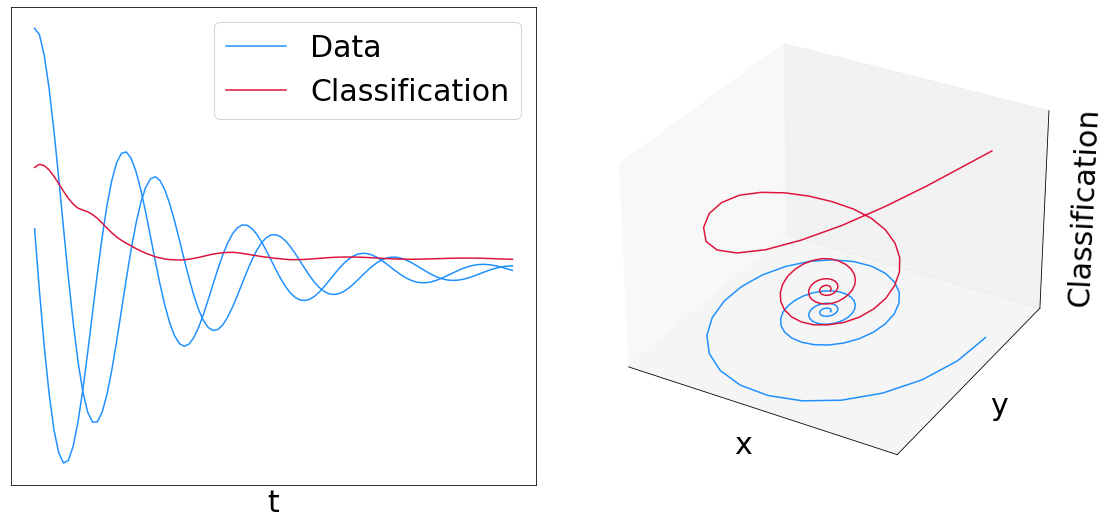

In [7]:
main()